In [157]:
import numpy as np
import scipy.stats as sci
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.stats import linregress
import pickle
import os
import time

In [199]:
def graphDisks(disks,sigma,L, phi, delta, t=0, save=True):
    fig, ax=plt.subplots(figsize=(5,5))

    err=1e-10
    for _,h in enumerate(disks):
        facecolor="red" if _==0 else "lightgray"
        c=plt.Circle((h[0],h[1]),sigma,facecolor=facecolor, edgecolor="black")
        ax.add_patch(c)
        edgecolor="black"
        
        if h[0]<(sigma+err):
            _c=plt.Circle((h[0]+L,h[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if h[0]>L-(sigma+err):
            _c=plt.Circle((h[0]-L,h[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if h[1]<(sigma+err):
            _c=plt.Circle((h[0]+L,h[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if h[1]>L-(sigma+err):
            _c=plt.Circle((h[0]-L,h[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)

        ax.set_xlim(0,L)
        ax.set_ylim(0,L)
    ax.set_aspect("equal")
    t = np.round(t, -1) if t!=0 else t
    #ax.set_title(f"phi:{phi} d:{delta} t:{t} n:{len(disks)}")
    ax.set_title(f"phi:{phi}")
    plt.show()
    if save==True:
        #fig.savefig(f"phi-{phi}-d{delta}-t{t}-n{len(disks)}.png")
        fig.savefig(f"phi-{phi}-steady.png")

def generate_grid(phi, delta,random=False):
    s = 32
    n_disks=1024
    sigma=1
    d0 = 2*sigma
    L = np.sqrt((np.pi * n_disks * sigma**2) / (phi))
    y_sep = d0 * np.sqrt(3)/2
    if random==False:
        cols = np.arange(sigma, s*d0, d0)  # x positions
        rows = np.arange(sigma, s*y_sep, y_sep) # y positions
    else:
        # random = True --> fill entire LxL space, select random.
        cols = np.arange(sigma, L-d0, d0)  # x positions
        rows = np.arange(sigma, L-y_sep, y_sep) # y positions

    disks = []

    for i, y in enumerate(rows):
        # stagger hex. grid
        if i % 2 == 0:
            x_positions = cols
        else:
            x_positions = cols + d0/2
        for x in x_positions:
            disks.append((x+sigma, y+sigma))
    disks = np.array(disks)
    if random==True:
        disks = disks[np.random.choice(len(disks), n_disks, replace=False)]
    else:
        disks = disks[:n_disks]

    graphDisks(disks,sigma,L, phi, delta, t=0, save=True)

    Lx = np.ptp(disks[:,0])
    Ly = np.ptp(disks[:,1])
    _phi = (np.pi * n_disks * sigma**2) / (L*L)

    print(f"phi,L=({_phi:.3f}, {L:.3f})")
    return disks, L

def diskDensity(n_slabs,disks,L):
    slab_width = L/n_slabs
    disk_density=[]
    slab_indices_x = np.floor(disks[:,0] / slab_width).astype(int)
    slab_indices_y = np.floor(disks[:,1] / slab_width).astype(int)
    
    counts_x = np.bincount(slab_indices_x, minlength=n_slabs)   
    counts_y = np.bincount(slab_indices_y, minlength=n_slabs)
    density_x = counts_x / slab_width
    density_y = counts_y / slab_width
    
    centers = (np.arange(n_slabs) + 0.5) * slab_width
    return centers, density_x, density_y

def monteCarloStep(n_disks, disks, disks_unwrapped, sigma, delta, L, periodic_boundary, moves, g=0.0, m=1.0, T=1.0):
    for n in range(n_disks):
        # Select random disk + random jump
        rand_disk = np.random.randint(len(disks))
        prev_pos = disks_unwrapped[rand_disk].copy()
        d = sigma * delta
        # Random displacement
        dx = np.random.uniform() - 0.5
        dy = np.random.uniform() - 0.5
        new_pos = prev_pos + np.array([d*dx, d*dy])
        new_pos=np.asarray(new_pos)
        err=1e-12
        new_pos_unwrapped = disks_unwrapped[rand_disk] + np.array([d*dx, d*dy])
        new_pos_unwrapped=np.asarray(new_pos_unwrapped)
        if periodic_boundary==True:
            diff = disks-(new_pos_unwrapped % L)
            diff -= L * np.round(diff / L)
        else:
            # hard boundary conditions
            if new_pos[0] < sigma-err or new_pos[0] > L-(sigma+err)\
                or new_pos[1] < sigma-err or new_pos[1] > L-(sigma+err):
                continue
            else:
                diff = disks - new_pos
        diff_sq = np.sum(diff**2, axis=1)
        diff_sq[rand_disk] = np.inf  # ignore self

        if np.any(diff_sq < (2 * sigma)**2):
            continue

        if g!=0.0 and periodic_boundary==False:
        # if force acting, calculate prob
            #T=1.0
            beta=1.0/T
            dE = m*g*(new_pos[1]-prev_pos[1])
            a=min([1.0, np.exp(-beta*dE)])
            if np.random.rand() < a:
                continue
            else:
                moves+=1
                disks_unwrapped[rand_disk] = new_pos_unwrapped
                disks[rand_disk] = new_pos_unwrapped % L
        else:
            moves+=1
            disks_unwrapped[rand_disk] = new_pos_unwrapped
            disks[rand_disk] = new_pos_unwrapped % L
    
    return disks, disks_unwrapped, moves

def monteCarloSimulation(n_steps, n_disks, disks, sigma, phi, delta, L, periodic_boundary, graphs=9):
    init=disks.copy()
    disks_unwrapped=disks.copy()
    disk_tracker=[]
    msd_step=[]
    cntrs=[]
    rho_x=[]
    rho_y=[]
    n_slabs=25
    tot_time=0
    t0 = time.time()
    for step in range(n_steps):
        moves=0
        disks, disks_unwrapped, moves = monteCarloStep(n_disks, disks, disks_unwrapped, sigma, delta, L, periodic_boundary, moves)
        
        displacements = disks_unwrapped - init  # vector displacement
        msd_step.append(np.sum(displacements**2, axis=1)) # msd per disk per t step
        if (step+1)%(int(n_steps/20))==0 and step!=0:
            t1 = time.time()
            iter_time = t1 - t0
            tot_time+=iter_time
            msd = np.mean(np.sum(displacements**2, axis=1))
            print(f"t={step+1} - {100*(moves/n_disks):.2f}% (MSD={msd:.5f})   |    t: {iter_time:.3f}s - total t:{int(tot_time)//60}{int(tot_time)%60}s")
            t0 = time.time()
        if (step+1)%(int(n_steps/graphs))==0 and step!=0:
            _cntrs, _rho_x, _rho_y = diskDensity(n_slabs, disks, L)
            cntrs.append(_cntrs)
            rho_x.append(_rho_x)
            rho_y.append(_rho_y)
            msd = np.mean(np.sum(displacements**2, axis=1))
            print(f"t={step+1} - {100*(moves/n_disks):.2f}% (MSD={msd:.5f})   |    t: {iter_time:.3f}s - total t:{int(tot_time)//60}{int(tot_time)%60}s")
            graphDisks(disks, sigma, L, phi, delta, step, save=True)
            
        disk_tracker.append(disks.copy())

    return disks, disk_tracker, rho_x, rho_y, cntrs, msd_step


In [159]:
def graphDisksUneven(disks,sigma, Lx, Ly, phi, delta, g, t=0, save=False):
    fig, ax=plt.subplots(figsize=(2,10))

    err=1e-10
    for _,h in enumerate(disks):
        facecolor="red" if _==0 else "lightgray"
        c=plt.Circle((h[0],h[1]),sigma,facecolor=facecolor, edgecolor="black")
        ax.add_patch(c)
        edgecolor="black"
        
        if h[0]<(sigma+err):
            _c=plt.Circle((h[0]+Lx,h[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if h[0]>Lx-(sigma+err):
            _c=plt.Circle((h[0]-Lx,h[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if h[1]<(sigma+err):
            _c=plt.Circle((h[0]+Ly,h[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if h[1]>Ly-(sigma+err):
            _c=plt.Circle((h[0]-Ly,h[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)

        ax.set_xlim(0,Lx)
        ax.set_ylim(0,Ly)
    #ax.set_aspect("")
    t = np.round(t, -1) if t!=0 else t
    ax.set_title(f"phi:{phi} d:{delta} g:{g} t:{t} n:{len(disks)}")
    #plt.tight_layout()
    plt.show()
    if save==True:
        fig.savefig(f"g{g}-phi-{phi}-d{delta}-t{t}-n{len(disks)}.png")

def generateGridUneven(phi, delta, g, random=True):
    s = 50
    n_disks=1024
    sigma=1
    d0 = 2*sigma
    L = np.sqrt((np.pi * n_disks * sigma**2) / (phi))
    Lx=s
    Ly=10*s
    y_sep = d0 * np.sqrt(3)/2
    cols = np.arange(sigma, Lx-d0, d0)  # x positions
    rows = np.arange(sigma, Ly-y_sep, y_sep) # y positions

    disks = []

    for i, y in enumerate(rows):
        # stagger hex. grid
        if i % 2 == 0:
            x_positions = cols
        else:
            x_positions = cols + d0/2
        for x in x_positions:
            disks.append((x+sigma, y+sigma))
    disks = np.array(disks)
    if random==True:
        disks = disks[np.random.choice(len(disks), int(n_disks), replace=False)]
    else:
        disks = disks[:n_disks]

    graphDisksUneven(disks, sigma, Lx, Ly, phi, delta,g, t=0,  save=True)
    _phi = (np.pi * n_disks * sigma**2) / (Lx*Ly)

    print(f"phi,L=({_phi:.3f}, {Lx:.3f} {Ly:.3f})")
    return disks, Lx, Ly

def monteCarloStepUneven(n_disks, disks, sigma, delta, Lx,Ly, moves, g, T=1.0,m=1.0):
    for n in range(n_disks):
        # Select random disk + random jump
        rand_disk = np.random.randint(len(disks))
        prev_pos = disks[rand_disk].copy()
        d = sigma * delta
        # Random displacement
        dx = np.random.uniform() - 0.5
        dy = np.random.uniform() - 0.5
        new_pos = prev_pos + np.array([d*dx, d*dy])
        new_pos=np.asarray(new_pos)
        err=1e-12

        if new_pos[0] < sigma-err or new_pos[0] > Lx-(sigma+err)\
            or new_pos[1] < sigma-err or new_pos[1] > Ly-(sigma+err):
            continue
        else:
            diff = disks - new_pos
        diff_sq = np.sum(diff**2, axis=1)
        diff_sq[rand_disk] = np.inf  # ignore self

        if np.any(diff_sq < (2 * sigma)**2):
            continue

        beta=1.0/T
        dE = m*g*(new_pos[1]-prev_pos[1])
        a=min([1.0, np.exp(-beta*dE)])
        if np.random.rand() < a:
            moves+=1
            disks[rand_disk] = new_pos
    
    return disks, moves

def monteCarloSimulationUneven(n_steps, n_disks, disks,disk_tracker, sigma, phi, delta, Lx, Ly, g, T,graphs=4):
    init=disks.copy()
    disk_tracker=[]
    msd_step=[]
    t0 = time.time()
    for step in range(n_steps):
        moves=0
        disks, moves = monteCarloStepUneven(n_disks, disks, sigma, delta, Lx, Ly, moves, g=g, T=T)
        displacements = disks - init  # vector displacement
        msd_step.append(np.sum(displacements**2, axis=1)) # msd per disk per t step
        if (step+1)%(int(n_steps/20))==0 and step!=0:
            t1 = time.time()
            iter_time = t1 - t0
            print(f"Time taken: {iter_time:.3f}s for {step+1} MC")
            t0 = time.time()
        if (step+1)%(int(n_steps/graphs))==0 and step!=0:
            msd = np.mean(np.sum(displacements**2, axis=1))
            print(f"t={step+1} - {100*(moves/n_disks):.2f}% (MSD={msd:.5f}) - Time taken: {iter_time:.3f}s")
            graphDisksUneven(disks, sigma, Lx+1, Ly, phi, delta,g, step, save=False)
            
        disk_tracker.append(disks.copy())

    return disks, disk_tracker, msd_step


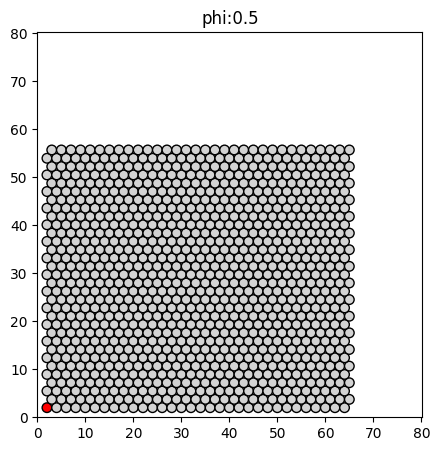

phi,L=(0.500, 80.212)
Run 0: d=0.1 L=80.21
t=500 - 24.12% (MSD=0.14528)   |    t: 26.336s - total t:026s
t=1000 - 37.11% (MSD=0.49669)   |    t: 25.785s - total t:052s
t=1500 - 45.21% (MSD=0.99315)   |    t: 26.525s - total t:118s
t=2000 - 58.79% (MSD=1.54059)   |    t: 26.117s - total t:144s
t=2500 - 64.26% (MSD=2.18623)   |    t: 26.924s - total t:211s
t=2500 - 64.26% (MSD=2.18623)   |    t: 26.924s - total t:211s


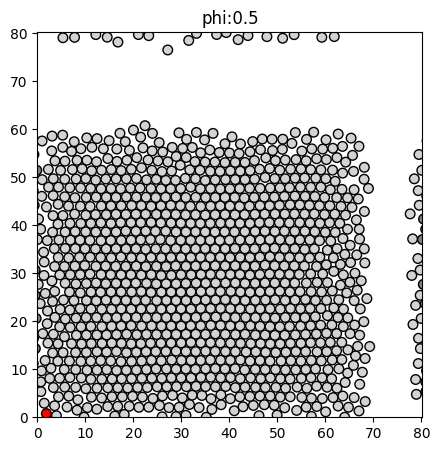

t=3000 - 66.80% (MSD=2.90221)   |    t: 28.289s - total t:239s
t=3500 - 72.56% (MSD=3.58513)   |    t: 26.548s - total t:36s
t=4000 - 72.66% (MSD=4.28149)   |    t: 26.278s - total t:332s
t=4500 - 77.05% (MSD=5.00198)   |    t: 26.948s - total t:359s
t=5000 - 77.15% (MSD=5.67709)   |    t: 26.457s - total t:426s
t=5000 - 77.15% (MSD=5.67709)   |    t: 26.457s - total t:426s


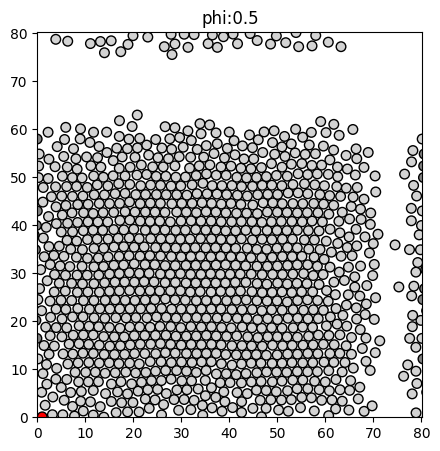

t=5500 - 78.71% (MSD=6.45355)   |    t: 28.181s - total t:454s
t=6000 - 77.93% (MSD=7.24823)   |    t: 26.604s - total t:520s
t=6500 - 83.11% (MSD=8.11581)   |    t: 26.834s - total t:547s
t=7000 - 82.71% (MSD=8.97577)   |    t: 26.660s - total t:614s
t=7500 - 84.57% (MSD=9.60635)   |    t: 26.905s - total t:641s
t=7500 - 84.57% (MSD=9.60635)   |    t: 26.905s - total t:641s


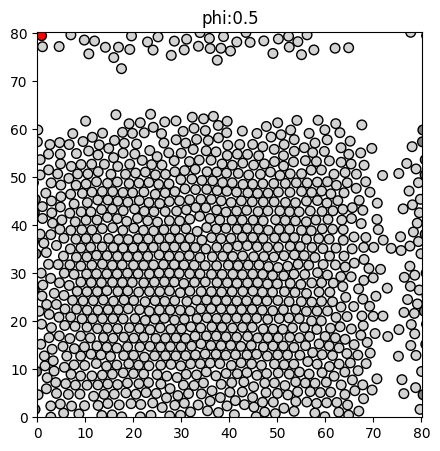

t=8000 - 81.54% (MSD=10.18751)   |    t: 28.927s - total t:710s
t=8500 - 82.91% (MSD=10.93522)   |    t: 26.624s - total t:736s
t=9000 - 85.45% (MSD=11.78416)   |    t: 26.811s - total t:83s
t=9500 - 84.28% (MSD=12.67091)   |    t: 26.705s - total t:830s
t=10000 - 82.81% (MSD=13.46666)   |    t: 26.646s - total t:857s
t=10000 - 82.81% (MSD=13.46666)   |    t: 26.646s - total t:857s


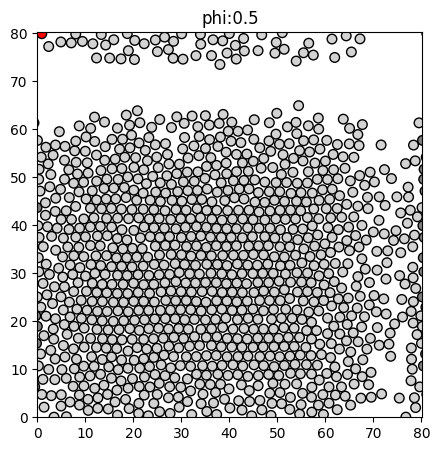

Time taken: 543.875s


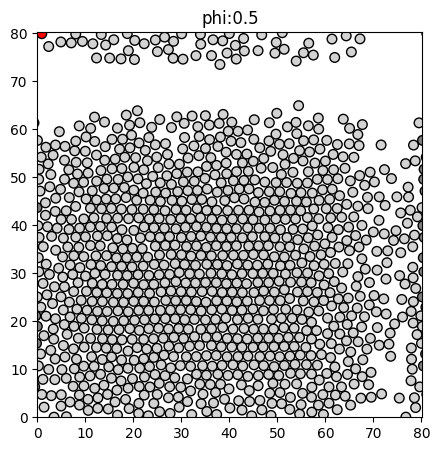

In [204]:
n_steps=10000
n_disks=1024
periodic_boundary=True
g=0.1
gs=[0.01,0.1,1,10]
T=1.0
phi=0.5
sigma=1
#deltas=[0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
#deltas=[0.3, 0.1, 0.03, 0.01, 0.001, 0.003]
deltas=[0.1]
msd_total=[]

start_time = time.time()
random=False
for run,_delta in enumerate(deltas):
    disks,L=generate_grid(phi, _delta, random)

    print(f"Run {run}: d={_delta} L={L:.2f}")
    t0 = time.time()
    disks, disk_tracker, rho_x, rho_y, cntrs, msd_step = monteCarloSimulation(n_steps, n_disks, disks, sigma, phi, _delta, L, periodic_boundary,graphs=4)
    msd_total.append(msd_step)
    
    t1 = time.time()
    iter_time = t1 - t0
    print(f"Time taken: {iter_time:.3f}s")

    # Dump positions into pickle file
    filename = os.path.join(os.getcwd(), f"POS_d{_delta}-phi{phi}-t{n_steps}-random{str(random)}.pkl")
    with open(filename, 'wb') as f:
        pickle.dump(disk_tracker, f)

    # Save Final Pos
    graphDisks(disks, sigma, L, phi, _delta, n_steps, save=True)

# Dump MSDs into pickle file
filename2 = os.path.join(os.getcwd(), f"MSD_phi{phi}-t{n_steps}-random{str(random)}.pkl")
with open(filename2, 'wb') as f:
    pickle.dump(msd_total, f)


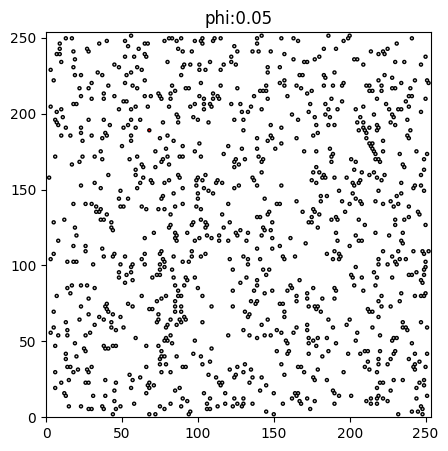

phi,L=(0.050, 253.653)


In [176]:
phi=0.05
_disks,_L=generate_grid(phi, _delta, True)

In [205]:
with open(filename2, 'rb') as f:
    msd_totals = pickle.load(f)
print(np.asarray(msd_totals).shape)

(1, 10000, 1024)


[0.1]
1.507 R2:0.998


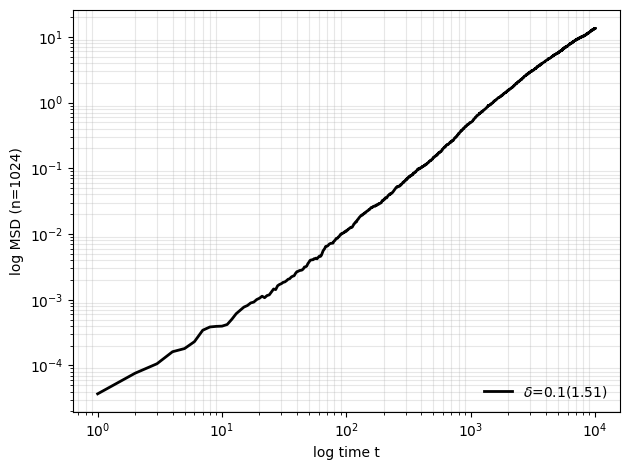

In [206]:
fig,ax=plt.subplots()
#deltas=[0.3, 0.1, 0.03, 0.01, 0.001, 0.003]
#deltas=[0.1]
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]
t=np.arange(0,n_steps)
msd_totals = np.asarray(msd_totals)
deltas=np.asarray(deltas)
sorted_indices = np.argsort(deltas)
deltas_sorted = deltas[sorted_indices]
print(deltas_sorted)
msd_sorted = msd_totals[sorted_indices]
plot_msd=True
if plot_msd==True:
    for m,msd_delta in enumerate(msd_sorted):
        msd_delta=np.asarray(msd_delta)
        log_t = np.log(t[1:])
        log_msd = np.log(np.mean(msd_delta[1:], axis=1))
        slope, intercept, r_value, p_value, stderr = linregress(log_t, log_msd)
        print(f"{slope:.3f} R2:{r_value:.3f}")
        #ax.plot(t[1:], np.mean(msd_delta[1:], axis=1))
        ax.loglog(t[1:], np.mean(msd_delta[1:], axis=1), color="black", linestyle=linestyles[m], 
                linewidth=2, label=f"$\delta$={deltas_sorted[m]}({slope:.2f})")
    handles, labels = ax.get_legend_handles_labels()

    legend1 = ax.legend(handles[2::-1], labels[2::-1], loc='lower right', frameon=False)
    legend2 = ax.legend(handles[:2:-1], labels[:2:-1], loc='upper left', frameon=False)
    ax.add_artist(legend1)
    ax.add_artist(legend2)
    ax.set_xlabel("log time t")
    ax.set_ylabel("log MSD (n=1024)")
    ax.grid(which="minor", alpha=0.3)
    #ax.set_title("log-log: MSD vs time")
    plt.tight_layout()
    plt.show()



plot_D = False
if plot_D==True:
    D_all = []
    slopes=[]
    print(msd_sorted.shape)
    for m,msd_delta in enumerate(msd_sorted):
        msd_delta=np.asarray(msd_delta)
        D = msd_delta / 4*t[:,None]
        D = np.array(D)
        print(D)
        log_t = np.log(t[1:])
        log_d = np.log(np.mean(D[1:], axis=1))
        slope, intercept, r_value, p_value, stderr = linregress(log_t, log_d)
        print(f"{slope:.3f} R2:{r_value:.3f}")
        #ax.plot(np.full(len(deltas),deltas[m]), np.mean(D[1:], axis=1))
        ax.loglog(t[1:], np.mean(D[1:], axis=1), color="black", linestyle=linestyles[m], 
                linewidth=2, label=f"$\delta$={deltas_sorted[m]}({slope:.2f})")
        D_all.append(D)
        slopes.append(slope)
    D_all = np.array(D_all)
    D_all = np.mean(D_all, axis=1)
    log_D_all = np.log(np.mean(D_all, axis=1))
    ax.plot(deltas_sorted, D_all, linestyle='-', linewidth=0.01)
    ax.plot(deltas_sorted, np.mean(D_all, axis=1), color="black", linestyle="-", linewidth=2, label=r"$D \sim \lim_{t \to \infty} \frac{\Delta(t)^{2}}{4t}$")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(plt.Line2D([0], [0], color='none'))
    lbl=r"$\frac{\log{D}}{\log{\delta}}\approx $"+f"{np.mean(slopes):.3f}" 
    labels.append(lbl)
    ax.legend(handles=handles, labels=labels)
    ax.set_xlabel(r"$\delta$")
    ax.set_ylabel(f"D - Diffusivity")
    #ax.set_xlabel(r"$\log{\delta}$")
    #ax.set_ylabel(r"$\log{D}$ - Diffusivity")
    ax.grid(which="minor", alpha=0.3)
    ax.set_ylim(0,4000)
    #ax.set_title("log-log: MSD vs time")
    plt.tight_layout()
    plt.show()

(4, 25)


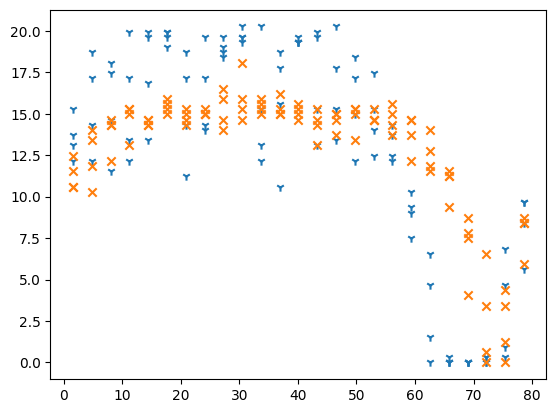

In [207]:
fig,ax=plt.subplots()
rho_x=np.asarray(rho_x)
print(rho_x.shape)
#ax.hist(rho_x, bins=len(rho_x))
ax.scatter(cntrs, rho_y,marker="1")
ax.scatter(cntrs, rho_x, marker='x')
plt.show()

In [ ]:

def densityEvolutionGrid(disk_tracker, L, n_slabs=50, cmap='plasma'):
    n_steps = disk_tracker.shape[0]
    step_indices = np.linspace(0, n_steps-1, 9, dtype=int)
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    # First pass: compute global vmin/vmax
    vmin, vmax = np.inf, -np.inf
    for step in step_indices:
        frame = disk_tracker[step]
        x = frame[:,0] % L
        y = frame[:,1] % L
        H, _, _ = np.histogram2d(x, y, bins=n_slabs, range=[[0,L],[0,L]])
        vmin = min(vmin, H.min())
        vmax = max(vmax, H.max())

    # Second pass: plot each snapshot
    for ax, step in zip(axes, step_indices):
        frame = disk_tracker[step]
        x = frame[:,0] % L
        y = frame[:,1] % L
        H, _, _ = np.histogram2d(x, y, bins=n_slabs, range=[[0,L],[0,L]])
        im = ax.imshow(H.T, origin='lower', extent=[0,L,0,L],
                       cmap=cmap, aspect='equal', vmin=vmin, vmax=vmax)
        ax.set_title(f"Step {step}", fontsize=8)
        ax.set_xticks([]); ax.set_yticks([])

    # Shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
    fig.colorbar(im, cax=cbar_ax, label='density')

    plt.subplots_adjust(left=0.05, right=0.9, top=0.93, bottom=0.05,
                        wspace=0.1, hspace=0.15)
    plt.suptitle("2D Density Snapshots at 9 Time Points", fontsize=12)
    plt.show()
disk_tracker = np.asarray(disk_tracker)
densityEvolutionGrid(disk_tracker, L, n_slabs=25)



In [ ]:
def plot9DensitySnapshots_rect(disk_tracker, Lx, Ly, n_slabs_x=1, n_slabs_y=15, loc=fname,cmap='plasma'):
    n_steps = disk_tracker.shape[0]
    step_indices = np.linspace(0, n_steps-1, 9, dtype=int)

    fig, axes = plt.subplots(1, 9,figsize=(20,20),      gridspec_kw=dict(wspace=0.02))   
    axes = axes.flatten()

    histograms = []
    for step in step_indices:
        frame = disk_tracker[step]
        x = frame[:, 0]
        y = frame[:, 1]
        # 2D histogram for rectangular box
        H, _, _ = np.histogram2d(x, y,bins=[n_slabs_x, n_slabs_y],range=[[0, Lx], [0, Ly]])
        histograms.append(H)

    vmin = min(H.min() for H in histograms)
    vmax = max(H.max() for H in histograms)

    # Plot each histogram
    ims = []
    for ax, H, step in zip(axes, histograms, step_indices):
        im = ax.imshow(
            H.T,
            origin='lower',
            extent=[0, Lx, 0, Ly],
            cmap=cmap,
            aspect='equal',
            vmin=vmin,
            vmax=vmax
        )
        ax.set_title(f"Step {step}", fontsize=7)
        ax.set_xticks([]); ax.set_yticks([])
        ims.append(im)

    # Shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    fig.colorbar(ims[0], cax=cbar_ax, label='density')
    plt.show()
    fig.savefig(f"")
filename = os.getcwd() + "/g0.01-POS_d1-phi0.1-t10000-randomTrue.pkl"
fname="g0.01-DENSITY_d1-phi0.1-t10000-randomTrue.png"
with open(filename, 'rb') as f:
    disk_tracker = pickle.load(f)

disk_tracker = np.asarray(disk_tracker)

plot9DensitySnapshots_rect(disk_tracker, Lx, Ly,
                           n_slabs_x=3, n_slabs_y=50, loc=fname)

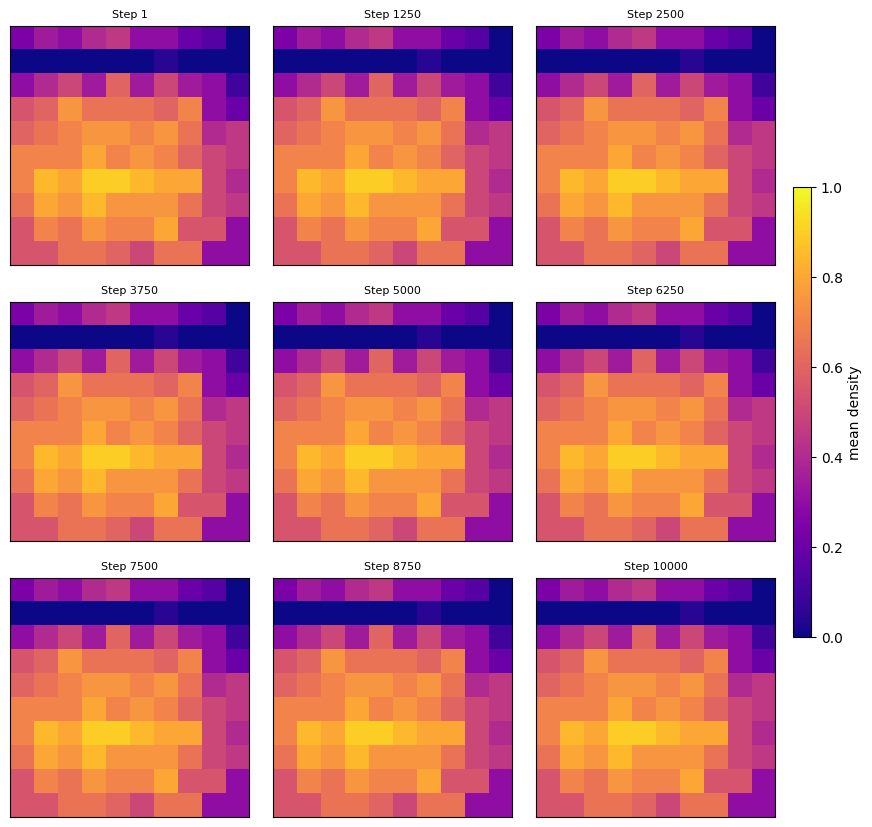

In [212]:
def plot9DensitySnapshots(disk_tracker, L, n_slabs=50, cmap='plasma'):
    n_steps = disk_tracker.shape[0]
    step_indices = np.linspace(0, n_steps-1, 9, dtype=int)

    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    axes = axes.flatten()

    # Compute histograms first to determine global vmin/vmax
    histograms = []
    for step in step_indices:
        frame = disk_tracker[step]
        x = frame[:, 0] % L
        y = frame[:, 1] % L
        H, _, _ = np.histogram2d(x, y, bins=n_slabs, range=[[0, L],[0,L]])
        histograms.append(H)

    vmin = min(H.min() for H in histograms)
    vmax = max(H.max() for H in histograms)
    _H = H / vmax
    # Plot each histogram in its own subplot
    ims = []
    vmin, vmax=0,1
    for ax, H, step in zip(axes, histograms, step_indices):
        im = ax.imshow(_H.T, origin='lower', extent=[0,L,0,L],
                       cmap=cmap, aspect='equal', vmin=vmin, vmax=vmax)
        ax.set_title(f"Step {step+1}", fontsize=8)
        ax.set_xticks([]); ax.set_yticks([])
        ims.append(im)

    # Add a single shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
    fig.colorbar(ims[0], cax=cbar_ax, label='mean density')

    plt.subplots_adjust(left=0.05, right=0.9, top=0.93, bottom=0.05,
                        wspace=0.1, hspace=0.15)
    #plt.suptitle("Density Snapshot", fontsize=12)
    plt.show()
filename=os.getcwd()+"/POS_d0.1-phi0.5-t10000-randomFalse.pkl"
with open(filename, 'rb') as f:
    disk_tracker = pickle.load(f)
disk_tracker = np.asarray(disk_tracker)
plot9DensitySnapshots(disk_tracker, L, n_slabs=10)



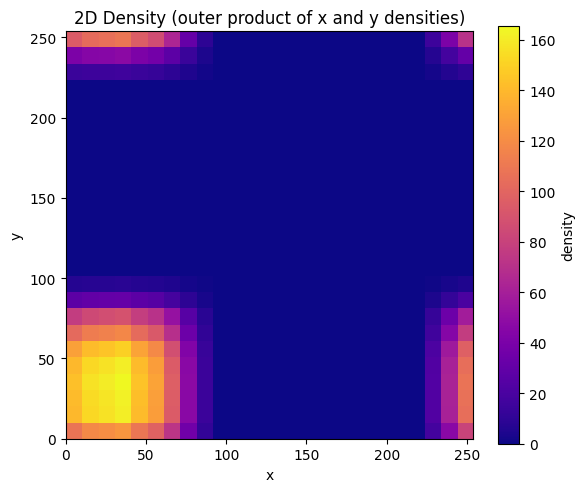

In [37]:
density_2d = np.outer(rho_y[1], rho_x[1])  # shape (n_slabs, n_slabs)

# Plot 2D density map
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(density_2d.T, origin='lower', extent=[0, L, 0, L], cmap='plasma', aspect='equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('2D Density (outer product of x and y densities)')
fig.colorbar(im, ax=ax, label='density')
plt.tight_layout()
plt.show()

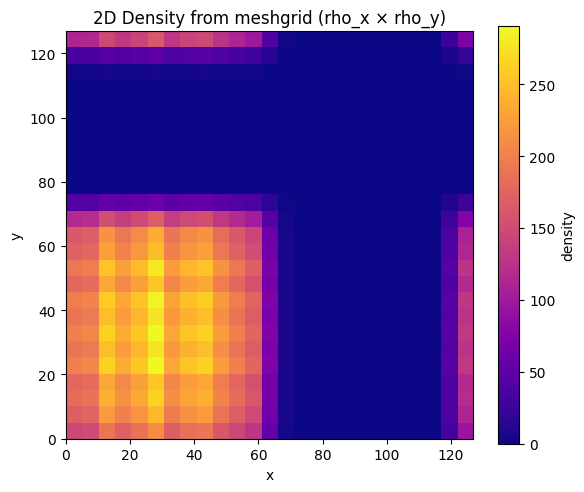

In [13]:
# Make 2D meshgrid of x and y densities
X, Y = np.meshgrid(rho_x[1], rho_y[1], indexing='xy')

# If the physical assumption is that density(x,y) = rho_x(x) * rho_y(y),
# compute the 2D density field:
density_2d = Y * X   # same as outer product but via meshgrid
# shape will be (len(rho_y), len(rho_x))

# Plot
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(
    density_2d.T,
    origin='lower',
    extent=[0, L, 0, L],
    cmap='plasma',
    aspect='equal'
)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('2D Density from meshgrid (rho_x × rho_y)')
fig.colorbar(im, ax=ax, label='density')

plt.tight_layout()
plt.show()
